In [1]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

The toy problem explores a 2-qubit system:
$$\big|\psi\rangle=\alpha\big|00\rangle+\beta\big|01\rangle+\gamma\big|10\rangle+\delta\big|11\rangle$$
where the amplitude for each state is a complex number while $\left|\alpha\right|^{2} = \left|\beta\right|^{2} + \left|\gamma\right|^{2} + \left|\delta\right|^{2} = 1$.

The quantum gates are unitary operation. We can pick some gates that are in SU(2), namely, Ry and Rz rotational gate.

$$R_y(\theta) = \left[\begin{array}{cc}
\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} & \cos \frac{\theta}{2}
\end{array}\right]$$

$$R_z(\theta) = \left[\begin{array}{cc}
e^{-i \theta / 2} & 0 \\
0 & e^{i \theta / 2}
\end{array}\right]$$

Since the qubit can also be represented on a Bloch sphere and ZYZ can specify any rotation, the qubit seems to be a homogeneous vector space for SU(2). As a result, we want to construct a NN that is equivariant to SU(2).

To construct a problem for NN to solve, we can choose regression or classification.

Regression: Input = The final statevector* (the 4 complex amplitudes); Output = The angle for each rotation

Classification: WIP. Classify between entangled and not entangled states?

*Note that the statevector is not measurable in the real world. We can only measure the qubit in a certain basis ($\langle \psi \big| \sigma_z  \big| \psi \rangle$) 

# Regression

## Validating Data

In [2]:
# Loading Dataset
hf = h5py.File("WIP_toy_qubit_regression.hdf5", "r")
X = np.array(hf.get("statevector"))
Y = np.array(hf.get("angles"))

In [3]:
# split the complex number into separate real and imag part
def splitc(l):
    splited = []
    for i in l:
        splited.append(i.real)
        splited.append(i.imag)
    return splited

In [4]:
X_splited = np.apply_along_axis(splitc, 1, X)
print(X_splited.shape)

(100000, 8)


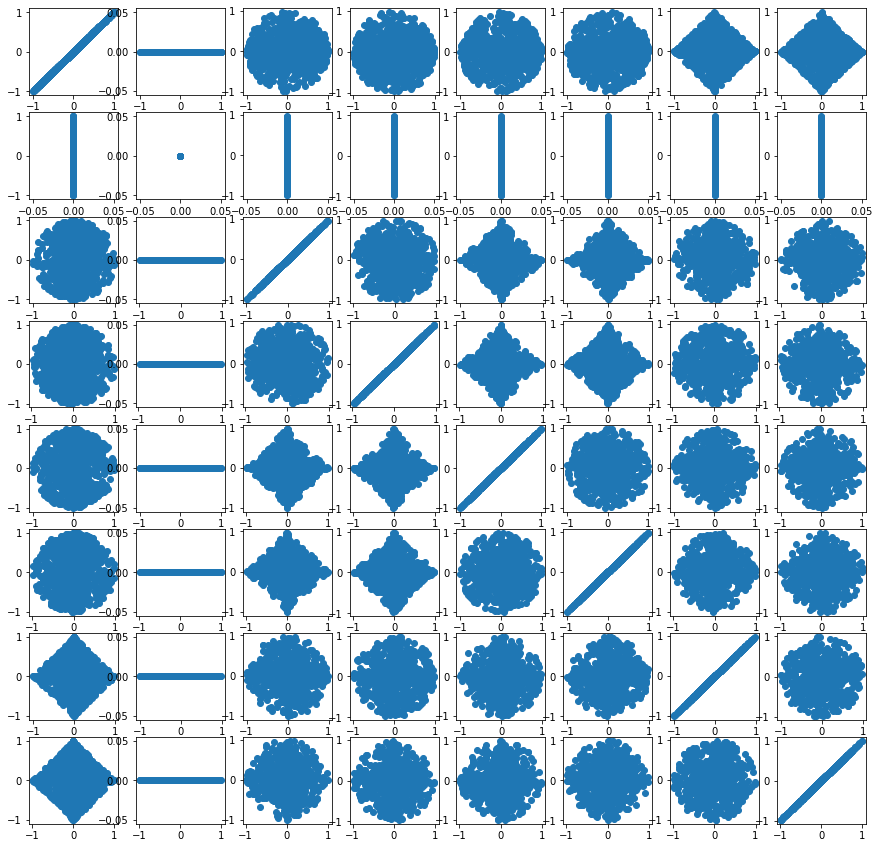

In [5]:
fig, ax = plt.subplots(8,8, figsize=(15,15))
for i in range(8):
    for j in range(8):
        ax[i,j].scatter(X_splited[:1000,i], X_splited[:1000,j])
plt.show()

## Train a Regression NN

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_splited, Y, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2)

In [8]:
print(x_test.shape,x_val.shape)

(16000, 8) (4000, 8)


In [9]:
print(x_train.shape)

(80000, 8)


In [10]:
class Net(nn.Module):
    def __init__(self, d_in, d_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(d_in, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, d_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
model = Net(d_in = 8, d_out = 6)
model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)


In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
criterion = torch.nn.MSELoss()

In [13]:
def train_epoch(model, optimizer, criterion, x_train, y_train, x_val, y_val, batch_size=50):
    train_loss = 0
    for i in range(0, x_train.shape[0], batch_size):
        inputv = Variable(torch.as_tensor(x_train[i:i+batch_size]).float()).to(device)
        targetv = Variable(torch.as_tensor(y_train[i:i+batch_size]).float()).to(device)
        
        output = model(inputv)
        loss = criterion(output, targetv)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    val_loss = 0
    with torch.no_grad():
        for i in range(0, x_val.shape[0], batch_size):
            inputv = Variable(torch.as_tensor(x_val[i:i+batch_size]).float()).to(device)
            targetv = Variable(torch.as_tensor(y_val[i:i+batch_size]).float()).to(device)
            output = model(inputv)
            loss = criterion(output, targetv)
            val_loss += loss
            
    return (train_loss/x_train.shape[0]), val_loss/x_val.shape[0]

In [14]:
epochs = 50
train_losses = []
val_losses = []
for e in range(epochs):
    train_loss, val_loss = train_epoch(model, optimizer, criterion, 
                                      x_train, y_train, x_val, y_val)
    print("Epoch:{}/{}; Train Loss:{}; Val Loss:{}".format(e, epochs, train_loss, val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch:0/50; Train Loss:0.06556800752878189; Val Loss:0.06441179662942886
Epoch:1/50; Train Loss:0.06345777213573456; Val Loss:0.06359032541513443
Epoch:2/50; Train Loss:0.06301843374967575; Val Loss:0.06314829736948013
Epoch:3/50; Train Loss:0.0627463236451149; Val Loss:0.06277387589216232
Epoch:4/50; Train Loss:0.06255541741847992; Val Loss:0.06262106448411942
Epoch:5/50; Train Loss:0.06242857500910759; Val Loss:0.06249474361538887
Epoch:6/50; Train Loss:0.0623391717672348; Val Loss:0.06249799206852913
Epoch:7/50; Train Loss:0.062280625104904175; Val Loss:0.06247243285179138
Epoch:8/50; Train Loss:0.06223108246922493; Val Loss:0.06242401897907257
Epoch:9/50; Train Loss:0.06219581887125969; Val Loss:0.06249231845140457
Epoch:10/50; Train Loss:0.062160562723875046; Val Loss:0.06246083602309227
Epoch:11/50; Train Loss:0.062136486172676086; Val Loss:0.0623868852853775
Epoch:12/50; Train Loss:0.06211302429437637; Val Loss:0.062447044998407364
Epoch:13/50; Train Loss:0.062091656029224396; V

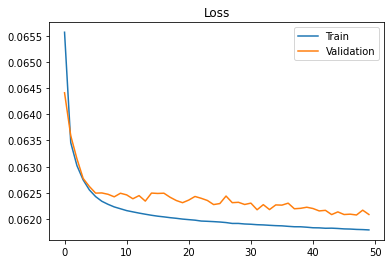

In [15]:
fig, ax = plt.subplots()
ax.set_title("Loss")
ax.plot(train_losses, label = "Train")
ax.plot(val_losses, label = "Validation")
ax.legend()
plt.show()

# Classification

## Validating Data

In [16]:
def check_entanglement(psi):
    a = psi[0]*psi[3] - psi[1]*psi[2]
    return "Not Entangled" if np.isclose(np.array([a]), np.array([0]))[0] else "Entangled"

In [17]:
# Loading Dataset
hf = h5py.File("WIP_toy_qubit_classification.hdf5", "r")
X0 = np.array(hf.get("not_entangled"))
X1 = np.array(hf.get("entangled"))

In [18]:
for i in np.random.randint(100000, size=10):
    print(check_entanglement(X0[i]))
    print(check_entanglement(X1[i]))

Not Entangled
Entangled
Not Entangled
Entangled
Not Entangled
Entangled
Not Entangled
Entangled
Not Entangled
Entangled
Not Entangled
Entangled
Not Entangled
Entangled
Not Entangled
Entangled
Not Entangled
Entangled
Not Entangled
Entangled


In [19]:
X0_splited = np.apply_along_axis(splitc, 1, X0)
X1_splited = np.apply_along_axis(splitc, 1, X1)

## Train a Classification NN

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
from sklearn.model_selection import train_test_split
Y0 = np.zeros(X0.shape[0])
Y1 = np.ones(X1.shape[0])
cx_train, cx_test, cy_train, cy_test = train_test_split(X0_splited+X1_splited, Y0+Y1, test_size=0.2)
cx_test, cx_val, cy_test, cy_val = train_test_split(cx_test, cy_test, test_size=0.2)

In [22]:
class cNet(nn.Module):
    def __init__(self, d_in):
        super(cNet, self).__init__()
        self.fc1 = nn.Linear(d_in, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [23]:
cmodel = cNet(d_in = 8)
cmodel.to(device)
print(cmodel)

cNet(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [24]:
coptimizer = torch.optim.Adam(cmodel.parameters(), lr=0.001, betas=(0.9, 0.999))
ccriterion = torch.nn.BCELoss()

In [25]:
epochs = 20
ctrain_losses = []
cval_losses = []
for e in range(epochs):
    ctrain_loss, cval_loss = train_epoch(cmodel, coptimizer, ccriterion, 
                                      cx_train, cy_train, cx_val, cy_val)
    print("Epoch:{}/{}; Train Loss:{}; Val Loss:{}".format(e, epochs, ctrain_loss, cval_loss))
    ctrain_losses.append(ctrain_loss)
    cval_losses.append(cval_loss)

/home/tdhttt/anaconda3/envs/qml/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/tdhttt/anaconda3/envs/qml/lib/python3.6/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch:0/20; Train Loss:0.0002686460502445698; Val Loss:5.236911988504289e-07
Epoch:1/20; Train Loss:2.241410754777462e-07; Val Loss:8.894694047967278e-08
Epoch:2/20; Train Loss:4.693913169262487e-08; Val Loss:2.376627072919746e-08
Epoch:3/20; Train Loss:1.330054466563979e-08; Val Loss:7.272969781979555e-09
Epoch:4/20; Train Loss:4.1693772878659274e-09; Val Loss:2.3585571273798678e-09
Epoch:5/20; Train Loss:1.366317614603929e-09; Val Loss:7.921460709603423e-10
Epoch:6/20; Train Loss:4.6056461422416817e-10; Val Loss:2.771616547381228e-10
Epoch:7/20; Train Loss:1.5920351148501766e-10; Val Loss:9.834764252980577e-11
Epoch:8/20; Train Loss:5.519448093016521e-11; Val Loss:3.57627816249817e-11
Epoch:9/20; Train Loss:1.7345038599847484e-11; Val Loss:1.3709072071987904e-11
Epoch:10/20; Train Loss:5.960459556475506e-12; Val Loss:5.960464760645934e-12
Epoch:11/20; Train Loss:1.7881384307277814e-12; Val Loss:3.5762792467003424e-12
Epoch:12/20; Train Loss:4.4703485162743417e-13; Val Loss:5.96046541

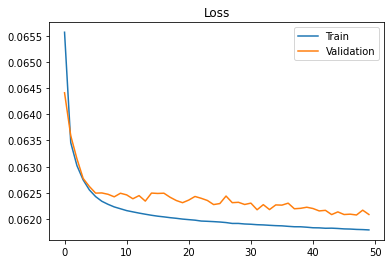

In [26]:
fig, ax = plt.subplots()
ax.set_title("Loss")
ax.plot(train_losses, label = "Train")
ax.plot(val_losses, label = "Validation")
ax.legend()
plt.show()